In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import json
import re

sparql = SPARQLWrapper("http://dbpedia-historique.inria.fr/sparql")
sparql.setQuery("""
    SELECT DISTINCT * WHERE
    {
      <http://fr.wikipedia.org/wiki/Hillary_Clinton> ?p ?v .
      OPTIONAL {?v ?p2 ?v2} 
    }
    ORDER BY ?v
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

            num       date
2004-07-01    4 2004-07-01
2004-08-01    1 2004-08-01
2004-09-01    4 2004-09-01
2004-11-01    5 2004-11-01
2004-12-01    2 2004-12-01


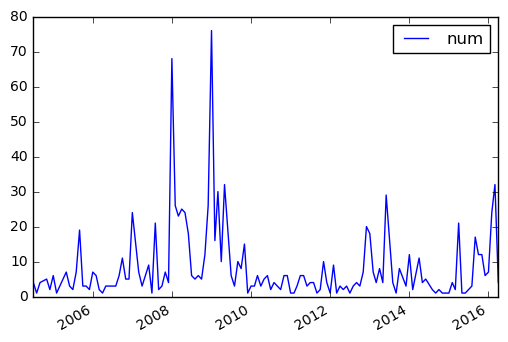

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
def convert_date(datestring, month=False):
    if month:
        return pd.to_datetime(datestring, format="%m/%Y")
    else:
        return pd.to_datetime(datestring, format="%Y")
    
    
def process_record(record):
    p = record['p']
    v = record['v']
    p2 = record['p2']
    v2 = record['v2']
    owner = num = date = None
    owner = v['value']
    month = False
    if re.search('integer', v2['datatype']):
        num = int(v2['value'])
    elif re.search('date', p2['value']):
        datestring = v2['value'].split("+")[0]
        if re.search("/", datestring):
            month = True
        date = convert_date(datestring, month)
    return owner, num, date
        
        
revPerYear = {}
for record in results["results"]["bindings"]:
    if len(record.keys()) < 4: 
        continue
    if re.search('revPerMonth', record['p']['value']):
        owner, num, date = process_record(record)
        if owner not in revPerYear:
            revPerYear[owner] = {'num': num, 'date': date}
        else:
            if revPerYear[owner]['num']:
                revPerYear[owner]['date'] = date
        
df = pd.DataFrame.from_dict(revPerYear, orient='index')
df.index = pd.DatetimeIndex(df.date)
print(df.head())
df.plot()

In [69]:
print(sum(df.num), max(df.num))

1123 76


In [71]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from collections import namedtuple
ADF = namedtuple("ADF", "adf pvalue usedlag nobs critical icbest")

ts = df.num
ADF(*smt.adfuller(ts))._asdict()

OrderedDict([('adf', -1.7710669181786862),
             ('pvalue', 0.39491779641872671),
             ('usedlag', 12),
             ('nobs', 121),
             ('critical',
              {'1%': -3.4855851458967542,
               '10%': -2.5796759080663887,
               '5%': -2.8857385662926651}),
             ('icbest', 902.5136819210104)])

In [72]:
ADF(*smt.adfuller(ts.diff().dropna()))._asdict()

OrderedDict([('adf', -4.7365627146854994),
             ('pvalue', 7.1804571718003918e-05),
             ('usedlag', 11),
             ('nobs', 121),
             ('critical',
              {'1%': -3.4855851458967542,
               '10%': -2.5796759080663887,
               '5%': -2.8857385662926651}),
             ('icbest', 897.66861006628892)])

In [73]:
diff = ts.diff()
Ldiff = diff.shift()
data = diff - Ldiff

mod_stationary = smf.ols('diff ~ Ldiff', data=data.dropna())
res_stationary = mod_stationary.fit()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbfcdff7080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfcdde1b38>)

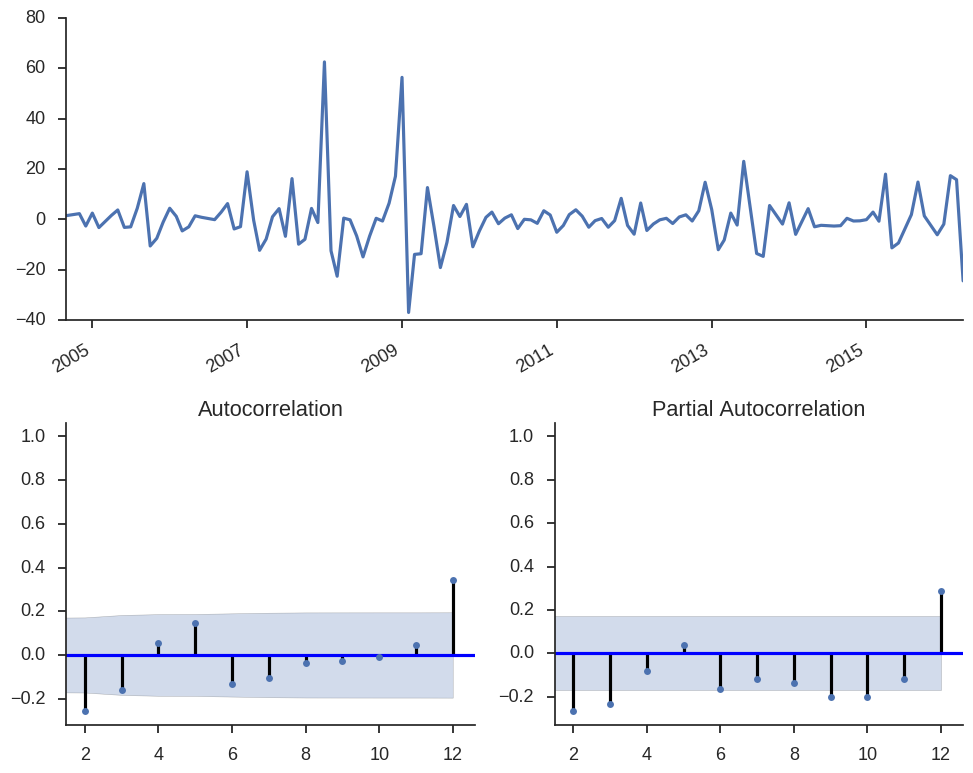

In [82]:
import seaborn as sns
sns.set(style='ticks', context='talk')

def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

tsplot(res_stationary.resid, lags=12)